In [227]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import yfinance as yf
import joblib
#plt.style.use('fivETHirtyeight')
#pdr.get_data_fred('GS10')

In [228]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
# download dataframe
df = pdr.DataReader("PBR", start="2012-01-01", end="2023-05-31")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,25.370001,26.340000,25.320000,26.110001,10.784527,12754300
2012-01-04,25.910000,26.580000,25.910000,26.459999,10.929094,12351500
2012-01-05,26.309999,26.370001,25.870001,26.110001,10.784527,8568600
2012-01-06,26.250000,26.250000,25.639999,25.690001,10.611050,8532100
2012-01-09,26.080000,26.969999,25.930000,26.879999,11.102569,26046600
...,...,...,...,...,...,...
2023-05-22,11.800000,11.800000,11.530000,11.550000,11.550000,13505800
2023-05-23,11.720000,11.970000,11.620000,11.790000,11.790000,13511000
2023-05-24,11.950000,12.050000,11.770000,11.970000,11.970000,15163700


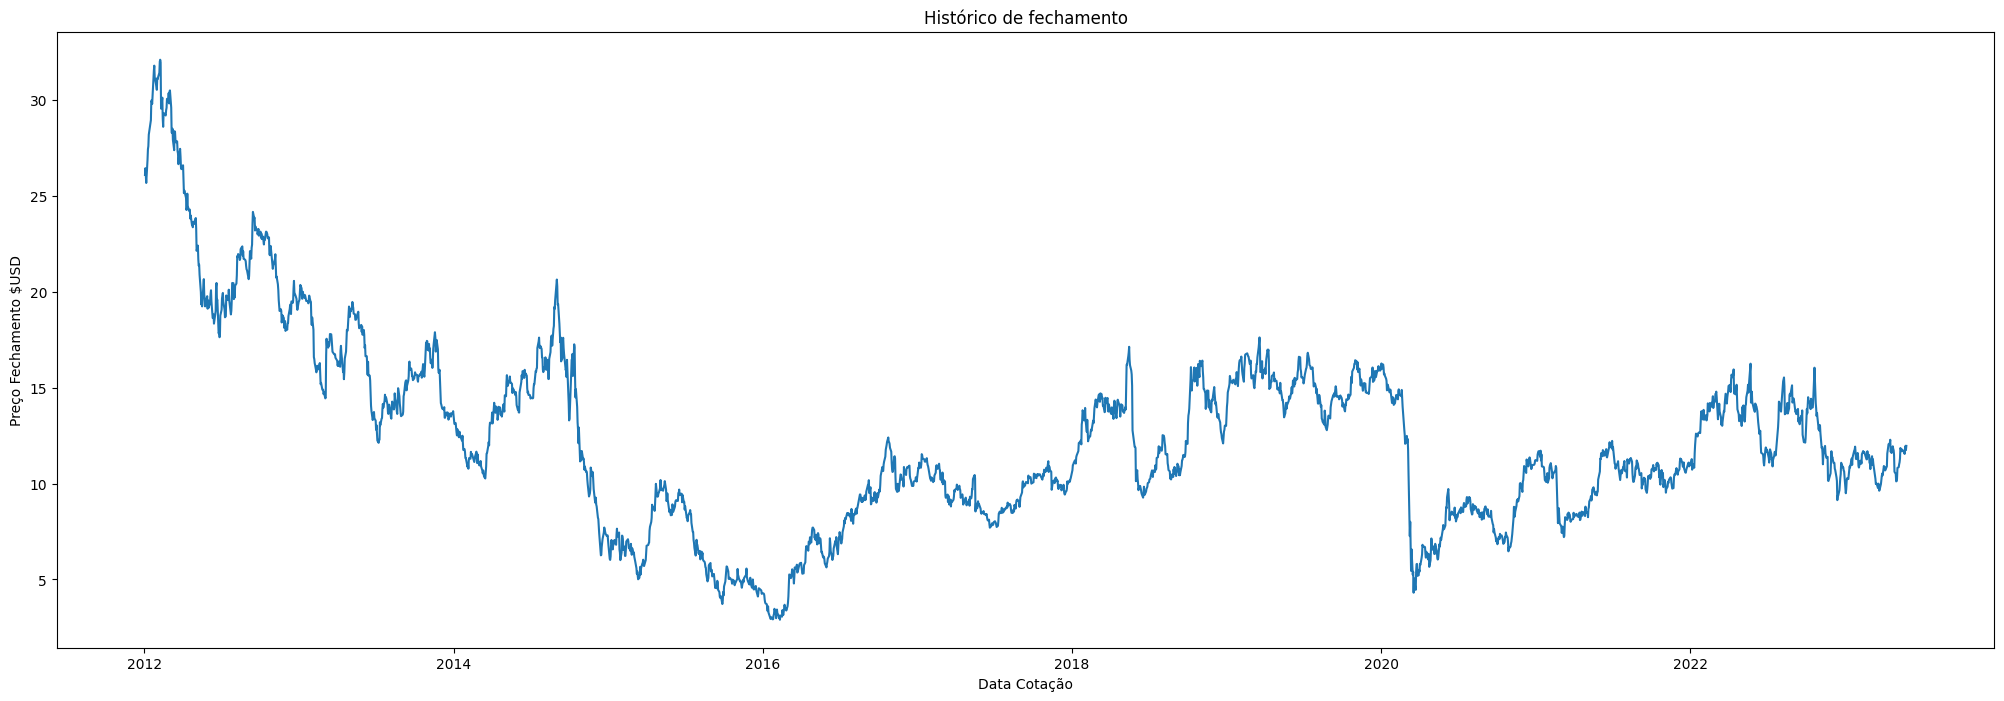

In [229]:
plt.figure(figsize=(25,8))
plt.title('Histórico de fechamento')
plt.plot(df['Close'])
plt.xlabel('Data Cotação')
plt.ylabel('Preço Fechamento $USD')
plt.show()

In [230]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) *.8)

In [231]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [232]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(x_train)
        print(y_train)

[array([0.79431901, 0.80629705, 0.79431901, 0.77994529, 0.82067077,
       0.84017802, 0.84565371, 0.86618754, 0.87132107, 0.89219713,
       0.92710475, 0.92607803, 0.92128681, 0.96509245, 0.98049282,
       0.98939085, 0.96885695, 0.96543469, 0.95242986, 0.94626969,
       0.96714582, 0.96543469, 0.96885695, 0.97672832, 0.99657774,
       1.        , 0.99555102, 0.91273103, 0.93223821, 0.89425057,
       0.88021909, 0.90485972, 0.90417524, 0.90041068, 0.90999318,
       0.91409999, 0.93018484, 0.92539362, 0.94045175, 0.92197129,
       0.94284743, 0.94524303, 0.91444222, 0.86995211, 0.86926763,
       0.87679676, 0.85660511, 0.83846682, 0.87234772, 0.87097883,
       0.85694735, 0.8524983 , 0.8542095 , 0.83675569, 0.83230665,
       0.81348395, 0.82340862, 0.84086243, 0.82717319, 0.80800825])]
[0.8045859236196595]


In [233]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [234]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2236, 60, 1)

In [235]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

In [236]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [237]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2236/2236 [==============================] - 73s 28ms/step - loss: 0.0026


In [238]:
# Salvar o modelo
model.save('model/modelo.h5')
# Salvar o scaler
joblib.dump(scaler, 'pickle/scaler.pkl')
# Carregar o modelo
model = load_model('model/modelo.h5')
# Carregar o scaler
scaler = joblib.load('pickle/scaler.pkl')

In [239]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [240]:
x_test = np.array(x_test)

In [241]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(573, 60, 1)

In [242]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

18/18 [==============================] - 4s 26ms/step


In [243]:
y_test = np.array(y_test).astype(float)

In [244]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

0.17388526640221294

In [245]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

C:\Users\bruno\AppData\Local\Temp\ipykernel_2832\2657761684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


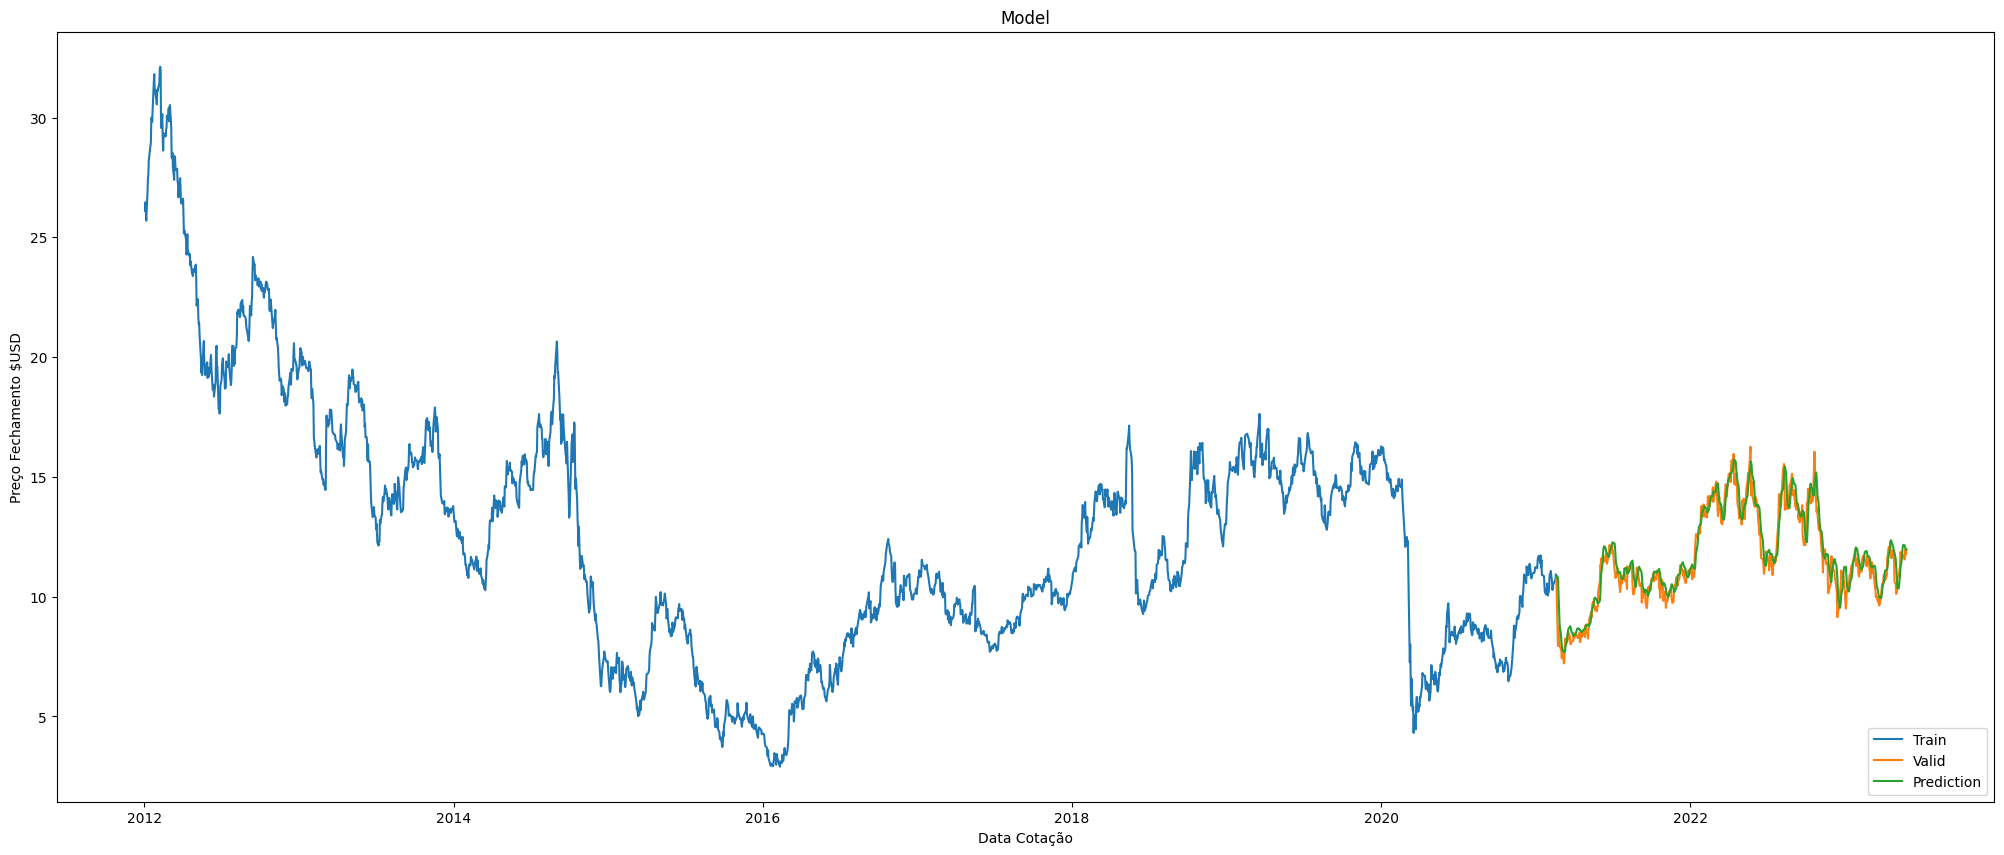

In [246]:
plt.figure(figsize=(25,10))
plt.title('Model')
plt.xlabel('Data Cotação')
plt.ylabel('Preço Fechamento $USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Prediction'], loc='lower right')
plt.show()

In [247]:
#valid

In [248]:
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
end = datetime.date.today()
yf.pdr_override() # <== that's all it takes :-)
# download dataframe
df = pdr.DataReader("PBR", start="2012-01-01", end=end)
df = df.filter(['Close'])
last_60_days = df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print("Preço futuro:", pred_price)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 121ms/step
Preço futuro: [[11.91453]]


In [249]:
quote = pdr.DataReader("PBR", start="2023-05-25", end='2023-05-31')
quote

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-25,11.84,11.91,11.68,11.75,11.75,17164400
2023-05-26,11.89,12.04,11.79,11.97,11.97,13125500
2023-05-30,11.80,11.84,11.58,11.73,11.73,17059300
